In [2]:
import src
import imp
import os
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gc

/opt/conda/lib/python3.7/site-packages/pvlib/solarposition.py:265: UserWarning: Reloading spa to use numba
  warnings.warn('Reloading spa to use numba')


In [3]:
pv_metadata_df = src.data.make_dataset.load_pv_metadata()

In [4]:
pv_metadata_df.head()

,system_name,system_size_watts,postcode,number_of_panels,panel_power_watts,panel_brand,num_inverters,inverter_power_watts,inverter_brand,orientation,...,install_date,latitude,longitude,status_interval_minutes,number_of_panels_secondary,panel_power_watts_secondary,orientation_secondary,array_tilt_degrees_secondary,x,y
system_id,,,,,,,,,,,,,,,,,,,,,
690,3.8kw of Power @ No3,3800,NaN,20,190,Phono Solar,1,4000,SMA Sunny Boy 4000,S,...,2010-12-01 00:00:00,52.087171,-0.263414,10,0,0,NaN,NaN,-18055.575382,5.773076e+06
709,Grove Cottages,2460,RG4,12,205,Romag PowerGlaz SMT6(54)P,1,3000,SMA Sunny Boy 3000TL,SE,...,2010-09-28 00:00:00,51.485329,-0.967526,5,0,0,NaN,NaN,-67206.360476,5.706524e+06
777,Underfell1,3420,NaN,18,190,Schuco MPE 190 MS 05,1,4000,SMA Sunny Boy 4000TL,SW,...,2010-10-29 00:00:00,54.197863,-2.938757,10,0,0,NaN,NaN,-191769.741882,6.011930e+06
794,Roofline,3700,GU34,20,185,Sharp,1,4000,SMA,SE,...,2011-01-05 00:00:00,51.112485,-1.032715,5,0,0,NaN,NaN,-72317.942054,5.665107e+06
973,number38,4000,WA11,16,250,Sungrid/SG250M6,1,3800,Sunny Boy 3800,SW,...,2011-01-13 00:00:00,53.467927,-2.675806,5,0,0,NaN,NaN,-177679.149748,5.930031e+06


In [5]:
pv_power_df = src.data.make_dataset.load_pv_power(start='2018-07-01', end='2019-08-20')

In [6]:
pv_power_df.head()

,690,709,973,1364,1556,1627,1646,1647,1872,1883,...,68000,68212,68218,68219,68303,68324,68404,68443,68800,68846
datetime,,,,,,,,,,,,,,,,,,,,,
2018-07-01 02:30:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-07-01 02:35:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-07-01 02:40:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-07-01 02:45:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-07-01 02:50:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
# Drop systems without PV data and metadata
src.features.preprocessing.filter_to_power_metadata_match(pv_metadata_df, pv_power_df)

In [8]:
# make clearsky GHI object
latitude, longitude = pv_metadata_df.loc[pv_power_df.columns, ['latitude', 'longitude']].values.T
ghiscalar = src.features.transformers.ClearskyScalar(latitude, longitude, g0=10)

# filter data to daylight hours
ghiscalar.filter_to_daylight(pv_power_df, min_ghi=5, inplace=True)

In [9]:
# scale by max power output
rminmax = src.features.transformers.RobustMinMaxScaler(saturation_fraction=0.01)
pv_prop_max_df = rminmax.fit_transform(pv_power_df)

In [10]:
# alternative scaling by GHI
pv_area_df = ghiscalar.transform(pv_power_df)

In [11]:
# alternative scaling by max effective area
area_rminmax = src.features.transformers.RobustMinMaxScaler(saturation_fraction=0.01)
pv_prop_area_df = area_rminmax.fit_transform(pv_area_df)

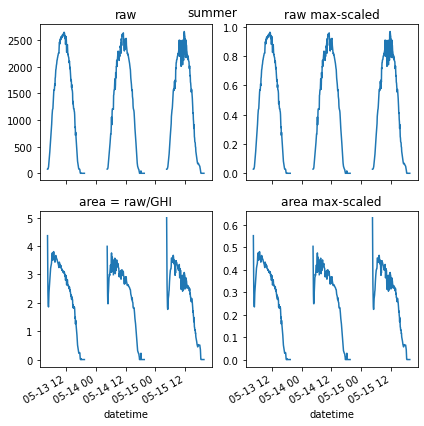

In [12]:
# have a look at outcome of scaling options
fig, axes = plt.subplots(2,2, figsize=(6,6), sharex=True)
for df, label, ax in zip([pv_power_df, pv_prop_max_df,  pv_area_df, pv_prop_area_df], ['raw', 'raw max-scaled', 'area = raw/GHI', 'area max-scaled'], axes.flatten()):
    df.loc['2019-05-13':'2019-05-15', pv_area_df.columns[3]].plot(ax=ax) 
    ax.set_title(label)
    plt.tight_layout()
fig.suptitle('summer')
plt.show()

I think this means we shouldn't scale by GHI as these seem to be remarkably clear days and the proportion of absorbed radiation is significanty different from 1.

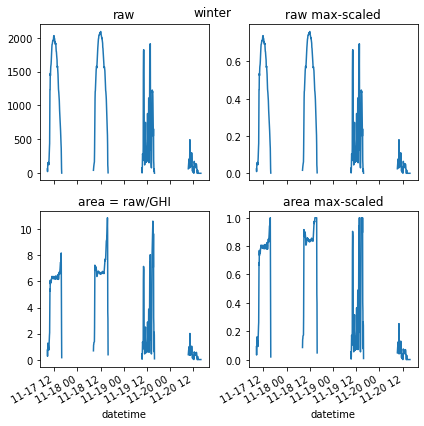

In [13]:
fig, axes = plt.subplots(2,2, figsize=(6,6), sharex=True)
for df, label, ax in zip([pv_power_df, pv_prop_max_df,  pv_area_df, pv_prop_area_df], ['raw', 'raw max-scaled', 'area = raw/GHI', 'area max-scaled'], axes.flatten()):
    df.loc['2018-11-17':'2018-11-20', pv_area_df.columns[3]].plot(ax=ax) 
    ax.set_title(label)
    plt.tight_layout()
fig.suptitle('winter')
plt.show()

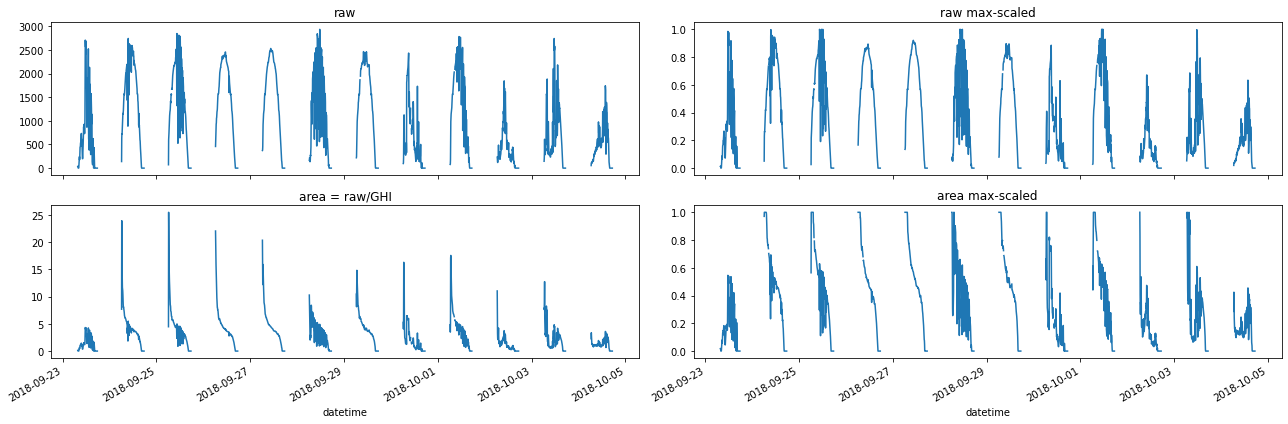

In [14]:
fig, axes = plt.subplots(2,2, figsize=(18,6), sharex=True)
for df, label, ax in zip([pv_power_df, pv_prop_max_df,  pv_area_df, pv_prop_area_df], ['raw', 'raw max-scaled', 'area = raw/GHI', 'area max-scaled'], axes.flatten()):
    df.loc['2018-09-23':'2018-10-04', pv_area_df.columns[3]].plot(ax=ax) 
    ax.set_title(label)
    plt.tight_layout()
#fig.suptitle('winter')
plt.show()

In [10]:
# calculate clearsky for feature and put in dataframe
clearsky = ghiscalar.haurwitz_ghi(pv_prop_max_df.index)
clearsky = (pd.DataFrame(clearsky, index=pv_prop_max_df.index, columns=pv_prop_max_df.columns)-ghiscalar.g0)/800

using:
```
S = xr.open_mfdataset(src.data.make_dataset.SATELLITE_FILE_PATTERN, drop_variables=['x', 'y'], combine='by_coords')
```

- 100% percentile was 103.32494
- 50% percentile was 12.876617
- 0% percentile was -0.2079

- Mean was 14.23
- Standard dev. was 12.876

In [11]:
satloader = src.data.make_dataset.SatelliteLoader()

   189 of   189

In [256]:
import imp
imp.reload(src.data.batch_loader)

<module 'src.data.batch_loader' from '/home/davidjamesfulton93/repos/predict_pv_yield/src/data/batch_loader.py'>

In [263]:
batch_generator = src.data.batch_loader.cross_processor_batch(
                    pv_prop_max_df.iloc[:100,:100], 
                    pv_metadata_df.loc[pv_prop_max_df.iloc[:100,:100].columns], 
                    clearsky,
                    satellite_loader=satloader,
                    nwp_loader=None,
                    batch_size=200, 
                    batches_per_superbatch=2, 
                    n_superbatches=2, 
                    n_epochs=None, 
                    gpu=False,
                    shuffle_datetime=True, 
                    method='fast')

In [264]:
%%time
bg = batch_generator
ps = 0
for batch in bg:
    ps+=bg.batch_size
    print('datetime index : {}'.format(bg.datetime_index))
    print('batch {} (superbatch {} - subbatch {}) - loaded {}'.format(bg.superbatch_index*bg.batches_per_superbatch +  bg.batch_index,
                                                                        bg.superbatch_index, bg.batch_index, ps))
    print ('epoch {} of {} | superbatch {} of {}\n'.format(bg.epoch, bg.n_epochs, bg.superbatch_index, bg.n_superbatches))
    
    if ps > 1000:
        break


datetime index : 5
batch 0 (superbatch 0 - subbatch 0) - loaded 200
epoch 0 of None | superbatch 0 of 2

datetime index : 5
batch 1 (superbatch 0 - subbatch 1) - loaded 400
epoch 0 of None | superbatch 0 of 2

datetime index : 10
batch 2 (superbatch 1 - subbatch 0) - loaded 600
epoch 0 of None | superbatch 1 of 2

datetime index : 10
batch 3 (superbatch 1 - subbatch 1) - loaded 800
epoch 0 of None | superbatch 1 of 2

CPU times: user 3.76 s, sys: 8 ms, total: 3.76 s
Wall time: 4.19 s


In [265]:
batch_generator = src.data.batch_loader.cross_processor_batch(
                    pv_prop_max_df.iloc[:100,:100], 
                    pv_metadata_df.loc[pv_prop_max_df.iloc[:100,:100].columns], 
                    clearsky,
                    satellite_loader=satloader,
                    nwp_loader=None,
                    batch_size=200, 
                    batches_per_superbatch=2, 
                    n_superbatches=2, 
                    n_epochs=None, 
                    gpu=False,
                    shuffle_datetime=True, 
                    method='random')

In [266]:
%%time
bg = batch_generator
ps = 0
for batch in bg:
    ps+=bg.batch_size
    print('datetime index : {}'.format(bg.datetime_index))
    print('batch {} (superbatch {} - subbatch {}) - loaded {}'.format(bg.superbatch_index*bg.batches_per_superbatch +  bg.batch_index,
                                                                        bg.superbatch_index, bg.batch_index, ps))
    print ('epoch {} of {} | superbatch {} of {}\n'.format(bg.epoch, bg.n_epochs, bg.superbatch_index, bg.n_superbatches))
    
    if ps > 1000:
        break


datetime index : 5
batch 0 (superbatch 0 - subbatch 0) - loaded 200
epoch 0 of None | superbatch 0 of 2

datetime index : 5
batch 1 (superbatch 0 - subbatch 1) - loaded 400
epoch 0 of None | superbatch 0 of 2

datetime index : 10
batch 2 (superbatch 1 - subbatch 0) - loaded 600
epoch 0 of None | superbatch 1 of 2

datetime index : 10
batch 3 (superbatch 1 - subbatch 1) - loaded 800
epoch 0 of None | superbatch 1 of 2

CPU times: user 15.6 s, sys: 424 ms, total: 16 s
Wall time: 16.6 s


In [267]:
pv_prop_max_df = pv_prop_max_df.reindex(pv_prop_max_df.index.intersection(satloader.index)).dropna(axis=0, how='all').dropna(axis=1, how='all')

In [268]:
TRAIN_FRAC = 0.9
train_mask = (
    (np.linspace(0,1,pv_prop_max_df.shape[0])[:, np.newaxis] < TRAIN_FRAC**0.5) & 
    (np.linspace(0,1,pv_prop_max_df.shape[1])[np.newaxis, :] < TRAIN_FRAC**0.5)
)

# test seen systems at unseen future times
test_time_mask = (
    (np.linspace(0,1,pv_prop_max_df.shape[0])[:, np.newaxis] > TRAIN_FRAC**0.5) & 
    (np.linspace(0,1,pv_prop_max_df.shape[1])[np.newaxis, :] < TRAIN_FRAC**0.5)
)

# test unseen systems at seen past and unseen future times
test_system_mask = (
    np.ones((pv_prop_max_df.shape[0],1), dtype=bool) & 
    (np.linspace(0,1,pv_prop_max_df.shape[1])[np.newaxis, :] > TRAIN_FRAC**0.5)
)

# choose single test mask 
test_mask = test_time_mask

In [269]:
y_train = pv_prop_max_df.where(train_mask)
meta_train = pv_metadata_df.copy()

y_train = y_train.dropna(axis=0, how='all').dropna(axis=1, how='all')

src.features.preprocessing.filter_to_power_metadata_match(meta_train, y_train)

In [52]:
latitude, longitude = meta_train.loc[y_train.columns, ['latitude', 'longitude']].values.T
ghiscalar = src.features.transformers.ClearskyScalar(latitude, longitude, g0=0)

clearsky_train = ghiscalar.haurwitz_ghi(y_train.index)
clearsky_train = (pd.DataFrame(clearsky_train, index=y_train.index, columns=y_train.columns)-ghiscalar.g0)/800

In [270]:
batch_generator = src.data.batch_loader.cross_processor_batch(
                    y_train, 
                    meta_train, 
                    clearsky_train,
                    satellite_loader=satloader,
                    nwp_loader=None,
                    batch_size=256, 
                    batches_per_superbatch=16, 
                    n_superbatches=None, 
                    n_epochs=1, 
                    gpu=True,
                    shuffle_datetime=True,
                    method='random')

In [271]:
y_test = pv_prop_max_df.where(test_mask)
meta_test = pv_metadata_df.copy()

y_test = y_test.dropna(axis=0, how='all').dropna(axis=1, how='all')

src.features.preprocessing.filter_to_power_metadata_match(meta_test, y_test)

In [272]:
latitude, longitude = meta_test.loc[y_test.columns, ['latitude', 'longitude']].values.T
ghiscalar = src.features.transformers.ClearskyScalar(latitude, longitude, g0=0)

clearsky_test = ghiscalar.haurwitz_ghi(y_test.index)
clearsky_test = (pd.DataFrame(clearsky_test, index=y_test.index, columns=y_test.columns)-ghiscalar.g0)/800

In [273]:
test_batch_generator = src.data.batch_loader.cross_processor_batch(
                    y_test, 
                    meta_test, 
                    clearsky_test,
                    satellite_loader=satloader,
                    nwp_loader=None,
                    batch_size=1000, 
                    batches_per_superbatch=1, 
                    n_superbatches=1, 
                    n_epochs=None, 
                    gpu=True,
                    shuffle_datetime=True,
                    method='random')

In [274]:
test_batch = next(test_batch_generator)

In [275]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import torch

In [276]:
class Net(nn.Module):
    def __init__(self, dropout_proportion=0.1):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=12, kernel_size=5)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=12, out_channels=16, kernel_size=5)
        HOURS_OF_DAY_CHANNELS = 1
        CLEARSKY_CHANNELS = 1
        self.fc1 = nn.Linear(16 * 29 * 29, 120)
        self.fc2 = nn.Linear(120 + HOURS_OF_DAY_CHANNELS + CLEARSKY_CHANNELS, 84)
        self.fc3 = nn.Linear(84, 1)#12)
        #self.fc4 = nn.Linear(12, 1)
        self.dropout1 = nn.Dropout(p=dropout_proportion)
        self.dropout2 = nn.Dropout(p=dropout_proportion)
        self.dropout3 = nn.Dropout(p=dropout_proportion)

    def forward(self, x, hour_of_day, clearsky):
        #x = self.dropout_layer(x)
        x = self.pool(F.relu(self.conv1(x)))
        # x is now <batch_size>, 6, 62, 62.  
        # 62 is 124 / 2.  124 is the 128-dim input - 4
        x = self.dropout1(x)
        x = self.pool(F.relu(self.conv2(x)))
        # x is now <batch_size>, 16, 29, 29
        x = x.view(-1, 16 * 29 * 29)
        # x is now <batch_size>, 16 x 29 x 29
        x = self.dropout2(x)
        x = F.relu(self.fc1(x))
        x = self.dropout3(x)
        x = torch.cat((x, hour_of_day, clearsky), dim=1)
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        #x = torch.sigmoid(self.fc4(x))
        return x

net = Net().cuda().half()

In [277]:
loss_func = nn.MSELoss()
mae_loss_func = nn.L1Loss()
optimizer = optim.SGD(net.parameters(), lr=0.01)

In [278]:
train_losses = []
train_mae_losses = []
test_losses = []
test_mae_losses = []

In [279]:
(~y_train.isna()).sum().sum() / (256*16*10)

26.683642578125

In [280]:
STATS_PERIOD = batch_generator.batches_per_superbatch*2

In [281]:
%%time

achieved_good_test_mae = False

t0 = time.time()

running_train_loss = 0.0
running_train_mae = 0.0

for i_batch, batch in enumerate(batch_generator):
    print('\rBatch: {:4d}'.format(i_batch), end='', flush=True)
    
    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    #net.train()
    outputs = net(batch['satellite'], batch['day_fraction'], batch['clearsky'])
    train_loss = loss_func(outputs, batch['y'])
    train_loss.backward()
    optimizer.step()
    running_train_loss += train_loss.item()

    # MAE
    train_mae = mae_loss_func(outputs, batch['y'])
    running_train_mae += train_mae.item()

    # print statistics
    if i_batch == 0 or i_batch % STATS_PERIOD == STATS_PERIOD - 1:    # print every STATS_PERIOD mini-batches
        t1 = time.time()

        # Train loss
        if i_batch == 0:
            mean_train_loss = running_train_loss
            mean_train_mae = running_train_mae
        else:
            mean_train_loss = running_train_loss / STATS_PERIOD
            mean_train_mae = running_train_mae / STATS_PERIOD

        train_losses.append(mean_train_loss)
        train_mae_losses.append(mean_train_mae)

        # Test loss
        #net.eval()
        test_outputs = net(test_batch['satellite'], test_batch['day_fraction'], test_batch['clearsky'])
        test_loss = loss_func(test_outputs, test_batch['y']).item()
        test_losses.append(test_loss)
        test_mae = mae_loss_func(test_outputs, test_batch['y']).item()
        test_mae_losses.append(test_mae)

        print(
            '\n        time =   {:.2f} milli seconds training per batch.\n'
            '   train loss = {:8.5f}\n'
            '    train MAE = {:8.5f}\n'
            '    test loss = {:8.5f}\n'
            '     test MAE = {:8.5f}\n'.format(
                ((t1 - t0) / STATS_PERIOD) * 1000,
                mean_train_loss, 
                mean_train_mae,
                test_loss,
                test_mae
            ))
        
        running_train_loss = 0.0
        running_train_mae = 0.0
        t0 = time.time()


print('\nFinished Training')

Batch:    0
        time =   4207.25 milli seconds training per batch.
   train loss =  0.30933
    train MAE =  0.44971
    test loss =  0.27319
     test MAE =  0.41040

Batch:   31
        time =   2777.83 milli seconds training per batch.
   train loss =  0.19139
    train MAE =  0.34364
    test loss =  0.10651
     test MAE =  0.27783

Batch:   63
        time =   5034.69 milli seconds training per batch.
   train loss =  0.10543
    train MAE =  0.27793
    test loss =  0.08295
     test MAE =  0.24976

Batch:   95
        time =   4802.87 milli seconds training per batch.
   train loss =  0.08275
    train MAE =  0.24784
    test loss =  0.06720
     test MAE =  0.22559

Batch:  127
        time =   4670.33 milli seconds training per batch.
   train loss =  0.06720
    train MAE =  0.22089
    test loss =  0.05783
     test MAE =  0.20544

Batch:  159
        time =   4720.15 milli seconds training per batch.
   train loss =  0.06092
    train MAE =  0.20591
    test loss =  0.

KeyboardInterrupt: 

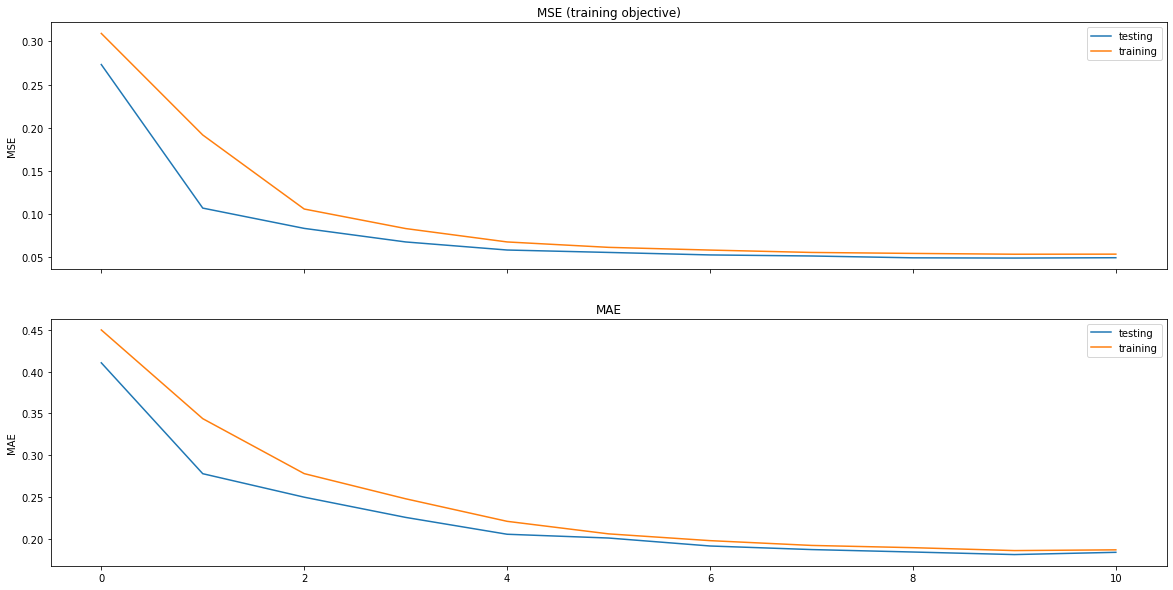

In [282]:
fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True, figsize=(20, 10))

ax1.plot(test_losses, label='testing')
ax1.plot(train_losses, label='training')
ax1.set_title('MSE (training objective)')
ax1.set_ylabel('MSE')
ax1.legend()

ax2.plot(test_mae_losses, label='testing')
ax2.plot(train_mae_losses, label='training')
ax2.set_title('MAE')
ax2.set_ylabel('MAE')
ax2.legend();

In [284]:
import seaborn as sns

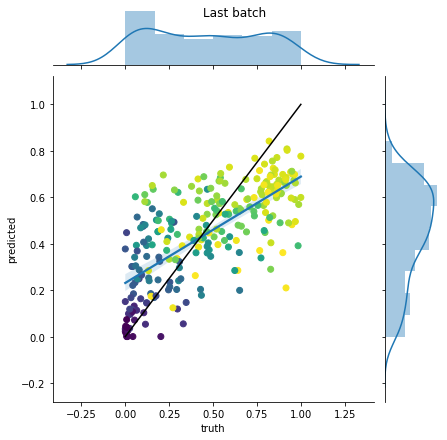

In [312]:
x = batch['y'].cpu().detach().numpy()
y = outputs.cpu().detach().numpy()
c=batch['clearsky'].cpu().detach().numpy()

g = sns.jointplot(x, y, kind='reg', scatter = False)
g.ax_joint.scatter(x, y, c=c)
g.ax_joint.plot([0,1], [0,1], color='k')
g.set_axis_labels(xlabel='truth', ylabel='predicted')
g.fig.suptitle('Last batch')
plt.show()

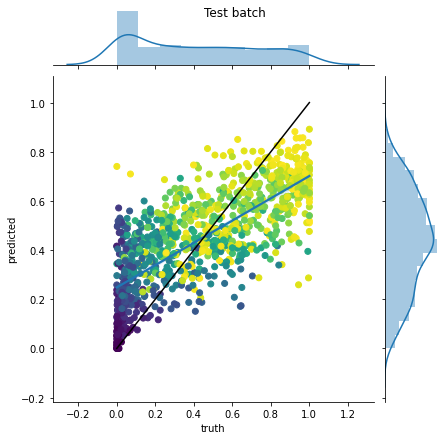

In [311]:

x = test_batch['y'].cpu().detach().numpy()
y = test_outputs.cpu().detach().numpy()
c=test_batch['clearsky'].cpu().detach().numpy()

g = sns.jointplot(x, y, kind='reg', scatter = False)
g.ax_joint.scatter(x, y, c=c)
g.ax_joint.plot([0,1], [0,1], color='k')
g.set_axis_labels(xlabel='truth', ylabel='predicted')
g.fig.suptitle('Test batch')
plt.show()



In [ ]:
# check that input data is correct and matches up

this_index = 253
this_batch = batch
thisorig_y_df = y_train
thisorig_clearsky_df = clearsky_train

def day_frac_to_time(frac):
    h = int(frac*24)
    m = int((frac*24  - int(frac*24))*60+0.25)
    return h,m

this_y = np.float16(float(this_batch['y'][this_index]))
this_clearsky = np.float16(float(this_batch['clearsky'][this_index]))
this_time = day_frac_to_time(np.float16(float(this_batch['day_fraction'][this_index])))
this_sat = this_batch['satellite'][this_index].cpu().detach().numpy()

print(this_y)
print(this_clearsky)
print('{:02}:{:02}:00'.format(*this_time))

mask =     (
            (abs(thisorig_y_df.astype(np.float16) - this_y)<1e-4) &
            (abs(thisorig_clearsky_df.astype(np.float16) - this_clearsky)<1e-4) &
            ((thisorig_y_df.index.hour==this_time[0]) & (thisorig_y_df.index.minute==this_time[1]))[:,np.newaxis]
           )

this_y_df = thisorig_y_df.where(mask).dropna(axis=0, how='all').dropna(axis=1, how='all').astype(np.float16)
this_clearsky_df = thisorig_clearsky_df.where(mask).dropna(axis=0, how='all').dropna(axis=1, how='all').astype(np.float16)

print(this_y_df)
print(this_clearsky_df)
satdiff = np.inf
for i in range(this_y_df.shape[0]):
    for j in range(this_y_df.shape[1]):
        satdiff = min(satdiff, np.max(np.abs((satloader.get_rectangle(this_y_df.index[i], *meta_test.loc[this_y_df.columns[j], ['x', 'y']]).values - this_sat))))
print(satdiff)